<a href="https://colab.research.google.com/github/peyman886/Deep_Learning_course/blob/main/HW3/HW3_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Information

## **Student Information:**
* Name = Peyman
* Last Name = Naseri
* Student ID = 96100522

## **HomeWork Information:**
* Course = Deep Learning
* Home Work = 3
* Question = 1
* colab = https://colab.research.google.com/drive/1SsplSNdj1cWgFWQiMQNVjbhQKfa3HdIG?usp=sharing
* github = https://github.com/peyman886/Deep_Learning_course/HW3/HW3_Q1.ipynb

# setting gpu

In [1]:
'''
  https://research.google.com/colaboratory/local-runtimes.html
  
  for run code on local gpu:
    run this comand in anaconda prompet:
      1) pip install jupyter_http_over_ws
      2) jupyter serverextension enable --py jupyter_http_over_ws
      3) jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

    copy url and paste on colab

'''
# !pip install numba 
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      # tf.config.experimental.set_virtual_device_configuration(gpu,
      #                                                         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])

  except RuntimeError as e:
    print(e)

#Check GPU

if len(tf.config.list_physical_devices('GPU')) > 0:
  !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
GeForce RTX 2080 with Max-Q Design, 461.33, 8192 MiB


In [2]:
# if gpus:
#   try:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#   except RuntimeError as e:
#     print(e)

# Twitter Sentiment Analysis

### importing

In [3]:
# !pip install gensim --upgrade

In [4]:
# DataFrame
import pandas as pd
import tensorflow as tf

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional, Input
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow_hub as hub

# import tokenization
from official.nlp.bert import tokenization
from official import nlp
from official.nlp import bert

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils

# Load the required submodules from official
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import csv


In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\peyma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [6]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 2
BATCH_SIZE = 512

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [7]:
dataset_filename = os.listdir("./input")[0]
dataset_path = os.path.join(".","input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path,encoding =DATASET_ENCODING
                 , names=DATASET_COLUMNS)

Open file: .\input\training.1600000.processed.noemoticon.csv


In [8]:
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [9]:
# df = df.iloc[1:]

In [10]:
# ds, info = tfds.load('sentiment140', with_info=True,
#                        # It's small, load the whole dataset
#                        batch_size=-1)

### Map target label to String
* **0,1** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **3,4** -> **POSITIVE**

In [11]:
decode_map = {0: "NEGATIVE", 1: "NEGATIVE",
              2: "NEUTRAL", 
              3: "POSITIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [12]:
df.target = df.target.apply(lambda x: decode_sentiment(x))


Text(0.5, 1.0, 'Dataset labels distribuition')

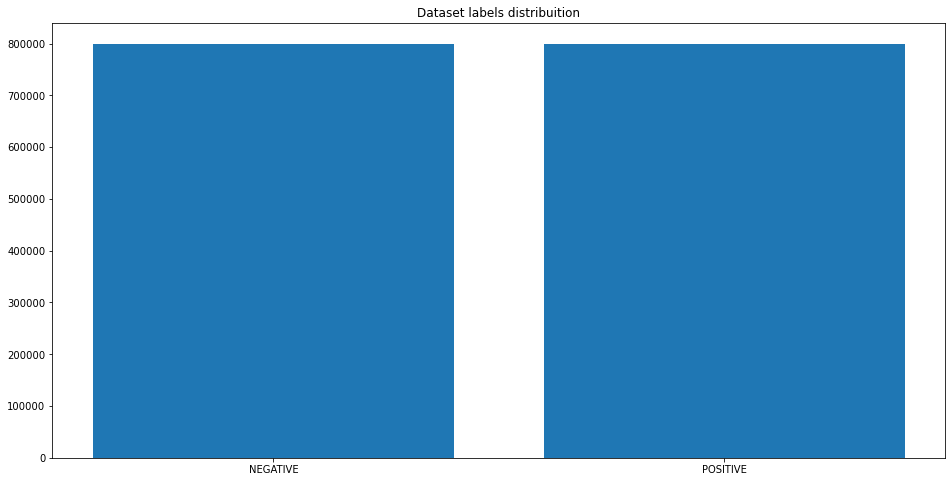

In [13]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [14]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [15]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [16]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 42.4 s


In [17]:
df.head(20)

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
5,NEGATIVE,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,whole crew
6,NEGATIVE,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug
7,NEGATIVE,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time see yes rains bit bit lol fine t...
8,NEGATIVE,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope
9,NEGATIVE,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera


In [18]:
# df.to_csv(dataset_path,index=False, header=False)

### Split train and test

In [19]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [20]:
del df

In [21]:
df_train

,target,ids,date,flag,user,text
1374558,POSITIVE,2051457557,Fri Jun 05 22:04:23 PDT 2009,NO_QUERY,JGoldsborough,ya quot like palm pre touchstone charger ready...
1389115,POSITIVE,2053083567,Sat Jun 06 03:12:21 PDT 2009,NO_QUERY,Psioui,felt earthquake afternoon seems epicenter
1137831,POSITIVE,1976779404,Sat May 30 19:02:49 PDT 2009,NO_QUERY,adriville,ruffles shirts like likey
790714,NEGATIVE,2325739990,Thu Jun 25 05:59:18 PDT 2009,NO_QUERY,Blondie128,pretty bad night crappy morning fml buttface d...
1117911,POSITIVE,1973503391,Sat May 30 11:16:35 PDT 2009,NO_QUERY,khrabrov,yeah clear view
...,...,...,...,...,...,...
259178,NEGATIVE,1985361990,Sun May 31 16:57:39 PDT 2009,NO_QUERY,lutheasalom,song middle change want born arghhhh
1414414,POSITIVE,2057029784,Sat Jun 06 12:14:24 PDT 2009,NO_QUERY,beeluz,good luck
131932,NEGATIVE,1835639354,Mon May 18 06:26:21 PDT 2009,NO_QUERY,lordmuttley,rather average 32370
671155,NEGATIVE,2246780174,Fri Jun 19 18:06:46 PDT 2009,NO_QUERY,MizSadittyFancy,pickin misstinayao waitin sadittysash 2 hurry ...


In [22]:
# x_train, x_test = df_train.copy(), df_test.copy()

### Word2Vec 

In [23]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 2.72 s


In [24]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
gensim.models.word2vec.Word2Vec()

2022-01-16 08:41:53,282 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=300, alpha=0.025)', 'datetime': '2022-01-16T08:41:53.282236', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
2022-01-16 08:41:53,286 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec(vocab=0, vector_size=100, alpha=0.025)', 'datetime': '2022-01-16T08:41:53.286773', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}


In [25]:
w2v_model.build_vocab(documents)

2022-01-16 08:41:53,304 : INFO : collecting all words and their counts
2022-01-16 08:41:53,306 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-01-16 08:41:53,338 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2022-01-16 08:41:53,357 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2022-01-16 08:41:53,376 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2022-01-16 08:41:53,392 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2022-01-16 08:41:53,407 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2022-01-16 08:41:53,424 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2022-01-16 08:41:53,441 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2022-01-16 08:41:53,457 : INFO : PROGRESS: at s

In [26]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [27]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2022-01-16 08:41:55,935 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7 shrink_windows=True', 'datetime': '2022-01-16T08:41:55.935126', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'train'}
2022-01-16 08:41:56,961 : INFO : EPOCH 1 - PROGRESS: at 21.03% examples, 1712545 words/s, in_qsize 16, out_qsize 0
2022-01-16 08:41:57,965 : INFO : EPOCH 1 - PROGRESS: at 42.68% examples, 1744022 words/s, in_qsize 14, out_qsize 1
2022-01-16 08:41:58,971 : INFO : EPOCH 1 - PROGRESS: at 64.62% examples, 1762294 words/s, in_qsize 16, out_qsize 0
2022-01-16 08:41:59,978 : INFO : EPOCH 1 - PROGRESS: at 86.31% examples, 1763790 words/s, in_qsize 14, out_qsize 1
2022-01-16 08:42:00,623 : INFO : worker thread finished; awaiting finish of 7 more threads
2022-01-16 08:42:00,627 : INFO : worker thr

Wall time: 2min 43s


(263121771, 295270528)

In [28]:
w2v_model.wv.most_similar("love")

[('luv', 0.5771451592445374),
 ('loves', 0.5498855113983154),
 ('loved', 0.5274569988250732),
 ('adore', 0.4997251033782959),
 ('amazing', 0.498043417930603),
 ('looove', 0.4842316806316376),
 ('loveee', 0.45608726143836975),
 ('awesome', 0.45491066575050354),
 ('lovee', 0.4492398202419281),
 ('miss', 0.43975794315338135)]

### Tokenize Text

In [29]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 12.9 s


In [30]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 18.9 s


In [31]:
# x_train = df_train.copy()
# x_train = df_test.copy()

### Label Encoder 

In [32]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [33]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [34]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [35]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

### Embedding layer

In [36]:
embeddings_dictionary = dict()
glove_file = open('glove.42B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
    
glove_file.close()

In [37]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
# for word, i in tokenizer.word_index.items():
#   if word in w2v_model.wv:
#     embedding_matrix[i] = w2v_model.wv[word]

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

print(embedding_matrix.shape)

(290419, 300)


In [38]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [39]:
def building(name, RNN_layer):
  model = Sequential(name=name)
  model.add(embedding_layer)
  model.add(Dropout(0.5))
  # model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
  if RNN_layer == 'pyramid':
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(8, dropout=0.2, recurrent_dropout=0.2))
  else:
    model.add(RNN_layer)
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  return model

### Compling Model

In [40]:
def compling(model):
  model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])

### Callbacks

In [41]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True)

callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5),
             checkpoint]

### Training Model

In [42]:
# x_train[].shape

In [43]:
def training(model, batch_size=BATCH_SIZE, epochs=EPOCHS,
             callbacks=None, steps_per_epoch=None,
             validation_steps=None
            #  ,validation_batch_size=BATCH_SIZE
             ):
  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.1,
                      verbose=1,
                      callbacks=callbacks,

                      # validation_data=None,
                      shuffle=True,
                      # class_weight=None,
                      # sample_weight=None,
                      # initial_epoch=0,
                      steps_per_epoch=steps_per_epoch,
                      validation_steps=validation_steps,
                      validation_batch_size=batch_size,
                      # validation_freq=1,
                      max_queue_size=10,
                      workers=12,
                      use_multiprocessing=True)
  return history



### Evaluation

In [73]:
def evaluation(model, history,
               batch_size=BATCH_SIZE, x_test = x_test
               ,steps=None):
  score = model.evaluate(x_test, y_test, batch_size=batch_size,
                         workers=12,use_multiprocessing=True
                         ,steps=steps)
  print()
  print("ACCURACY:",score[1])
  print("LOSS:",score[0])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  
  plt.figure()
  
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  
  plt.show()

### Prediction 

In [45]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [137]:
def predict(model, text
            ,batch_size,steps
            , include_neutral=True
            ,x_test=x_test):
    start_at = time.time()
    # Tokenize text
    # x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict(x = x_test,batch_size=batch_size,
                          steps = steps,workers=10,use_multiprocessing=True)[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [141]:
def prediction(model, batch_size=None,steps = None, x_test=x_test):
  print(predict(model=model,
                batch_size=batch_size, steps = steps,
                x_test=x_test, text="I love the music"))
  print(predict(model=model,
                batch_size=batch_size, steps = steps,
                x_test=x_test, text="I hate the rain"))
  print(predict(model=model,
                batch_size=batch_size, steps = steps,
                x_test=x_test, text="i don't know what i'm doing"))


### Confusion Matrix

In [81]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [143]:
def confusionMatrix(model, x_test=x_test,
                    batch_size=None,steps = None):
  y_pred_1d = []
  y_test_1d = list(df_test.target)
  # y_test_1d = list(y_test.reshape(-1))
  scores = model.predict(x_test, verbose=1,
                         batch_size=batch_size
                         ,workers=10,
                         use_multiprocessing=True,
                         steps=steps)
  y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]
  y_test_1d = y_test_1d[:len(y_pred_1d)]
  print(len(y_pred_1d))
  cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
  plt.figure(figsize=(12,12))
  plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
  plt.show()

  print('\n\n\n')
  ### Classification Report
  print('classification_report :',classification_report(y_test_1d, y_pred_1d))
  print('\n\n\n')
  ### Accuracy Score
  print('accuracy_score :',accuracy_score(y_test_1d, y_pred_1d))

In [115]:
# y_test.shape
len(list(df_test.target))

320000

In [118]:
len(list(y_test.reshape(-1)))

320000

### Saving model

In [50]:
# EXPORT
# KERAS_MODEL = "model.h5"
# WORD2VEC_MODEL = "model.w2v"
# TOKENIZER_MODEL = "tokenizer.pkl"
# ENCODER_MODEL = "encoder.pkl"

def saving(model):
  model.save(model.name + '.h5')

# model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2022-01-16 08:47:19,233 : INFO : Word2Vec lifecycle event {'fname_or_handle': 'model.w2v', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-01-16T08:47:19.233076', 'gensim': '4.1.2', 'python': '3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
2022-01-16 08:47:19,234 : INFO : not storing attribute cum_table
2022-01-16 08:47:19,328 : INFO : saved model.w2v


### loading model


In [51]:
from keras.models import load_model
def loading(model):
  model=load_model(model.name + '.h5')
  return model


# الف

In [ ]:
RNN_layer = LSTM(150, dropout=0.2, recurrent_dropout=0.2)
modelA = building(name='LSTM', RNN_layer=RNN_layer)


Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 150)               270600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 87,396,451
Trainable params: 270,751
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
BATCH_SIZE = 512
compling(model=modelA)
history = training(model=modelA, batch_size=BATCH_SIZE)

Epoch 1/2
2250/2250 [==============================] - 2016s 895ms/step - loss: 0.5149 - accuracy: 0.7420 - val_loss: 0.4676 - val_accuracy: 0.7757
Epoch 2/2
2250/2250 [==============================] - 2069s 919ms/step - loss: 0.4836 - accuracy: 0.7641 - val_loss: 0.4550 - val_accuracy: 0.7832


625/625 [==============================] - 130s 208ms/step - loss: 0.4538 - accuracy: 0.7837

ACCURACY: 0.7836687564849854
LOSS: 0.45378291606903076


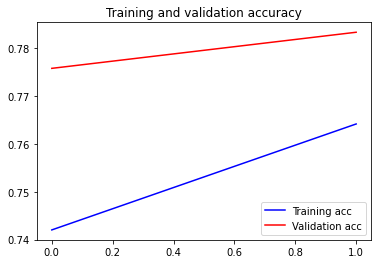

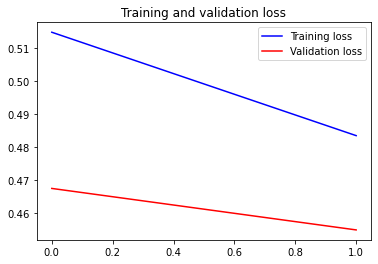

In [ ]:
evaluation(model=modelA, history=history, batch_size=BATCH_SIZE)

In [ ]:
prediction(model=modelA)

{'label': 'POSITIVE', 'score': 0.9803071618080139, 'elapsed_time': 0.3967266082763672}
{'label': 'NEGATIVE', 'score': 0.008493189699947834, 'elapsed_time': 0.18339228630065918}
{'label': 'NEUTRAL', 'score': 0.4736991822719574, 'elapsed_time': 0.17055010795593262}


400/400 [==============================] - 88s 219ms/step


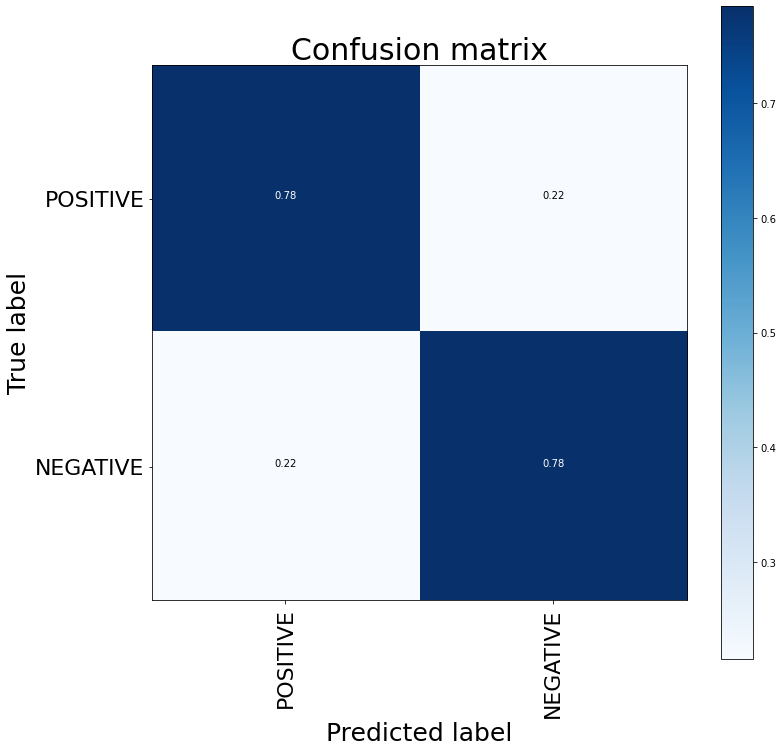





classification_report :               precision    recall  f1-score   support

    NEGATIVE       0.78      0.78      0.78    159494
    POSITIVE       0.78      0.78      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000





accuracy_score : 0.78366875


In [ ]:
confusionMatrix(model=modelA)

In [ ]:
saving(model=modelA)

In [ ]:
# loading(model=modelA)

# ب

In [ ]:
RNN_layer = Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.2)) 
modelB = building(name='Bidirectional_LSTM', RNN_layer=RNN_layer)


Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout_1 (Dropout)         (None, 300, 300)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 300)              541200    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 301       
                                                                 
Total params: 87,667,201
Trainable params: 541,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [ ]:
BATCH_SIZE = 256
compling(model=modelB)
history = training(model=modelB, batch_size=BATCH_SIZE)

Epoch 1/2
4500/4500 [==============================] - 7394s 2s/step - loss: 0.5092 - accuracy: 0.7460 - val_loss: 0.4645 - val_accuracy: 0.7774
Epoch 2/2
4500/4500 [==============================] - 6684s 1s/step - loss: 0.4842 - accuracy: 0.7640 - val_loss: 0.4540 - val_accuracy: 0.7842


1250/1250 [==============================] - 430s 344ms/step - loss: 0.4525 - accuracy: 0.7848

ACCURACY: 0.7848374843597412
LOSS: 0.45254024863243103


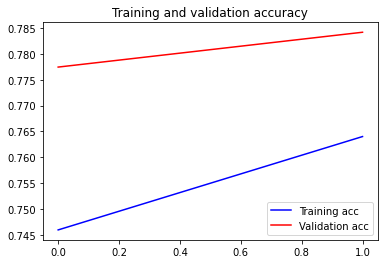

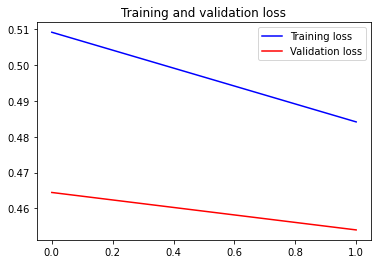

In [ ]:
evaluation(model=modelB, history=history, batch_size=BATCH_SIZE)

In [ ]:
prediction(model=modelB)

{'label': 'POSITIVE', 'score': 0.9718393087387085, 'elapsed_time': 0.6199617385864258}
{'label': 'NEGATIVE', 'score': 0.008831162005662918, 'elapsed_time': 0.32263851165771484}
{'label': 'NEUTRAL', 'score': 0.4357672333717346, 'elapsed_time': 0.31203579902648926}


400/400 [==============================] - 134s 333ms/step


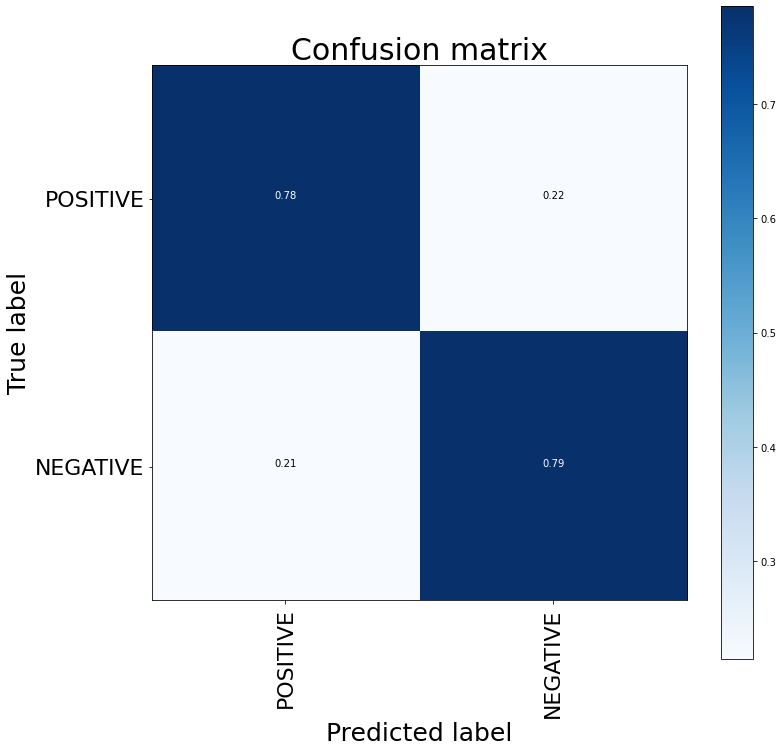





classification_report :               precision    recall  f1-score   support

    NEGATIVE       0.78      0.78      0.78    159494
    POSITIVE       0.79      0.79      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000





accuracy_score : 0.7848375


In [ ]:
confusionMatrix(model=modelB)

In [ ]:
saving(model=modelB)

# ج

In [ ]:
RNN_layer = 'pyramid'
modelC = building(name='pyramid', RNN_layer=RNN_layer)


Model: "pyramid"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout_2 (Dropout)         (None, 300, 300)          0         
                                                                 
 lstm_2 (LSTM)               (None, 300, 64)           93440     
                                                                 
 lstm_3 (LSTM)               (None, 300, 32)           12416     
                                                                 
 lstm_4 (LSTM)               (None, 300, 16)           3136      
                                                                 
 lstm_5 (LSTM)               (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 1)                 9   

In [ ]:
BATCH_SIZE = 256
compling(model=modelC)
history = training(model=modelC, batch_size=BATCH_SIZE)

Epoch 1/2
4500/4500 [==============================] - 17619s 4s/step - loss: 0.5195 - accuracy: 0.7398 - val_loss: 0.4698 - val_accuracy: 0.7754
Epoch 2/2
4500/4500 [==============================] - 16504s 4s/step - loss: 0.4886 - accuracy: 0.7612 - val_loss: 0.4578 - val_accuracy: 0.7820


1250/1250 [==============================] - 879s 703ms/step - loss: 0.4565 - accuracy: 0.7829

ACCURACY: 0.7829468846321106
LOSS: 0.45648622512817383


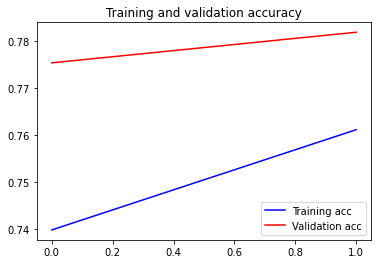

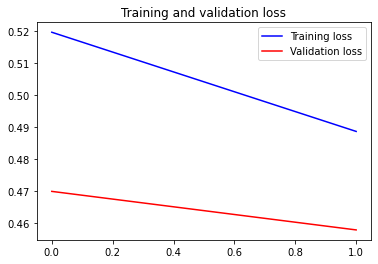

In [ ]:
evaluation(model=modelC, history=history, batch_size=BATCH_SIZE)

In [ ]:
prediction(model=modelC)

{'label': 'POSITIVE', 'score': 0.9633448123931885, 'elapsed_time': 1.114103078842163}
{'label': 'NEGATIVE', 'score': 0.023349370807409286, 'elapsed_time': 0.5920596122741699}
{'label': 'NEUTRAL', 'score': 0.4668908715248108, 'elapsed_time': 0.5752029418945312}


400/400 [==============================] - 263s 655ms/step


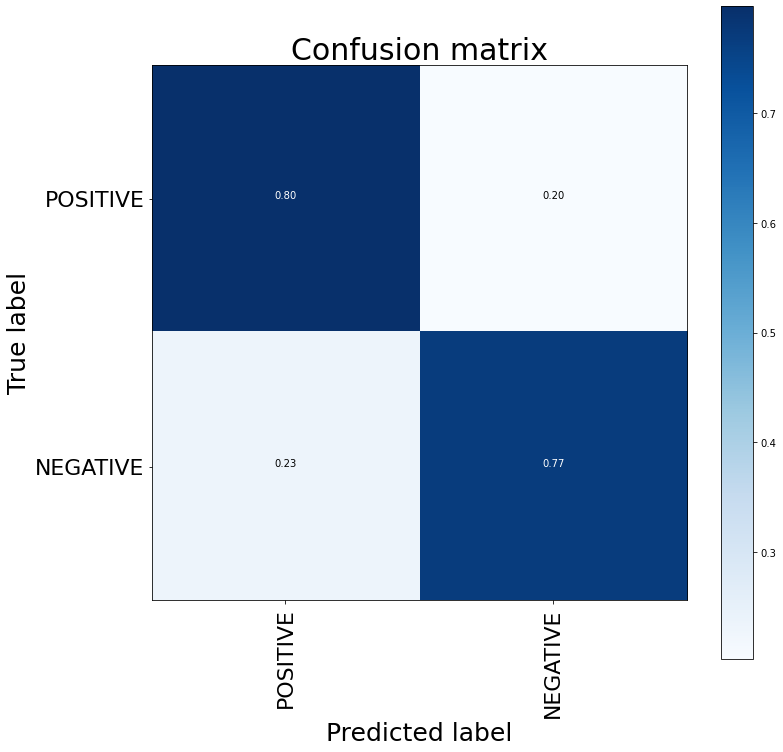





classification_report :               precision    recall  f1-score   support

    NEGATIVE       0.77      0.80      0.79    159494
    POSITIVE       0.79      0.77      0.78    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000





accuracy_score : 0.782946875


In [ ]:
confusionMatrix(model=modelC)

In [ ]:
saving(model=modelC)

# د
برای این قسمت یه سری کد های بالا رو تغییر دادم چون 

In [52]:
# ! pip install tensorflow-text
# ! pip install tf-models-official

In [53]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [54]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    # model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [55]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=False)

2022-01-16 08:47:20,761 : INFO : Using C:\Users\peyma\AppData\Local\Temp\tfhub_modules to cache modules.


Wall time: 13 s


In [56]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [57]:
print("Vocab size:", len(tokenizer.vocab))
tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

Vocab size: 30522
['hello', 'tensor', '##flow', '!']
[7592, 23435, 12314, 999]


In [58]:
# processor = nlp.data.classifier_data_lib.TfdsProcessor(
#     tfds_params='dataset=sentiment140:1.0.0,text_key=text',
#     process_text_fn=bert.tokenization.convert_to_unicode)


In [59]:
# x_train_backup = x_train.copy()
# y_train_backup = y_train.copy()
# x_test_backup = x_test.copy()
# y_test_backup = y_test.copy()

In [60]:
x_train = bert_encode(df_train.text.values, tokenizer, max_len=300)
x_test = bert_encode(df_test.text.values, tokenizer, max_len=300)
# y_train = df_train.target.values


In [134]:
modelD.predict?

In [62]:
# x_train = x_train[:len(x_train)//2]
# y_train = y_train[:len(y_train)//2]


In [63]:
modelD = build_model(bert_layer, max_len=300)
modelD.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 300)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 1024),       335141889   ['input_word_ids[0][0]',         
                                 (None, 300, 1024)]               'input_mask[0][0]',         

In [64]:
# change size of data
# x_train = x_train[:len(x_train)//2]
# x_test = x_train[:len(x_train)//2]


In [65]:
compling(model=modelD)

BATCH_SIZE = 128

history = training(model=modelD, batch_size=BATCH_SIZE
         ,steps_per_epoch=1000
        #  , validation_steps=100,
        #  validation_batch_size=16
         )



Epoch 1/2
1000/1000 [==============================] - 13540s 14s/step - loss: 0.5812 - accuracy: 0.6878 - val_loss: 0.5620 - val_accuracy: 0.7075
Epoch 2/2
1000/1000 [==============================] - 13195s 13s/step - loss: 0.5573 - accuracy: 0.7102 - val_loss: 0.5573 - val_accuracy: 0.7112


100/100 [==============================] - 656s 7s/step - loss: 0.5579 - accuracy: 0.7109

ACCURACY: 0.7108593583106995
LOSS: 0.557885468006134


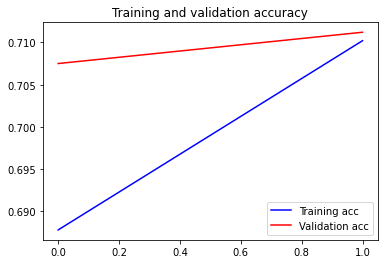

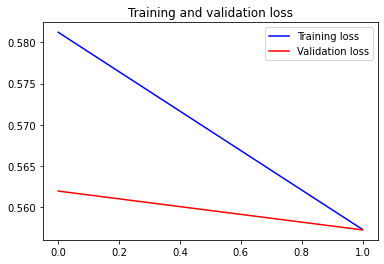

In [75]:
evaluation(model=modelD, history=history,
           batch_size=BATCH_SIZE, x_test=x_test
           ,steps=100)

In [83]:
len(x_train[1].shape)

2

In [84]:
x_train[0].shape

(1280000, 300)

In [96]:
x_test[0].shape


(320000, 300)

In [98]:
y_test.shape

(320000, 1)

In [142]:
prediction(model=modelD,x_test = x_test,batch_size=128,steps = 10)

{'label': 'NEUTRAL', 'score': 0.6373156309127808, 'elapsed_time': 61.92710757255554}
{'label': 'NEUTRAL', 'score': 0.6373156309127808, 'elapsed_time': 63.69207835197449}
{'label': 'NEUTRAL', 'score': 0.6373156309127808, 'elapsed_time': 64.6482503414154}


100/100 [==============================] - 656s 7s/step
12800


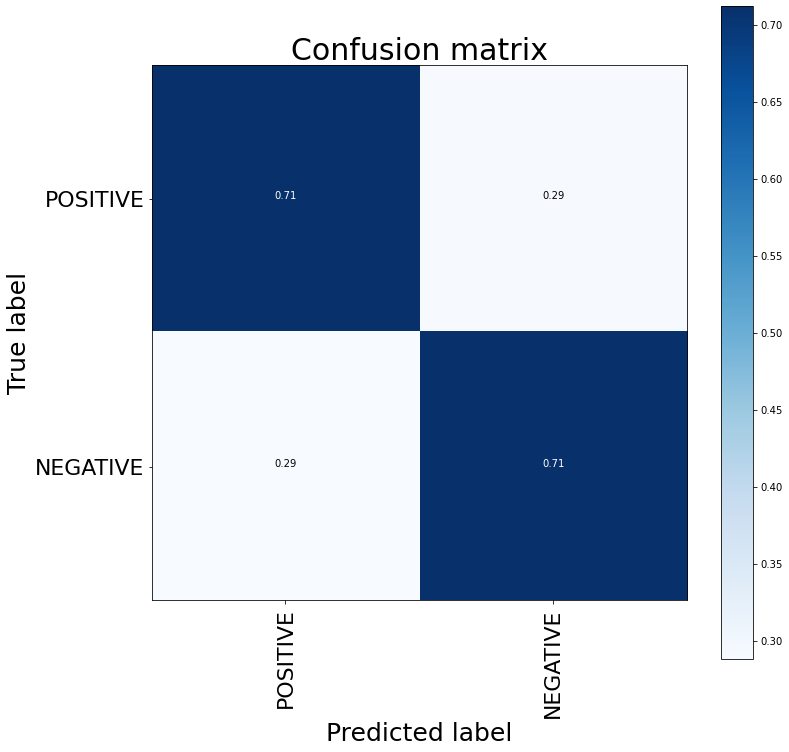





classification_report :               precision    recall  f1-score   support

    NEGATIVE       0.71      0.71      0.71      6391
    POSITIVE       0.71      0.71      0.71      6409

    accuracy                           0.71     12800
   macro avg       0.71      0.71      0.71     12800
weighted avg       0.71      0.71      0.71     12800





accuracy_score : 0.710859375


In [146]:
confusionMatrix(model=modelD,
                x_test=x_test ,batch_size=128, steps = 100)

In [145]:
saving(model=modelD)